In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#from tqdm import tqdm

mpl.rcParams['axes.spines.top'] = 0
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['axes.spines.left'] = 1
mpl.rcParams['axes.spines.bottom'] = 1
mpl.rcParams.update({'font.size': 12})

(ch:introduction)=
# Introduction 


## What is the plan?

Pattern recognition is about recognizing patterns. It is almost synonymous with supervised learning, although unsupervised learning plays an important role in feature design. To really understand pattern recognition you need to get comfortable with a certain amount of math, perhaps more than you would like. This will be hard unless you believe in it and perhaps even like it.

In order to create context for all that math, instead of starting by history or philosophy or by defining "patterns" and "recognitions", let us start by writing some code to recognize patterns.


## The MNIST dataset

We will work with a notorious dataset of handwritten digits called MNIST. According to this interview, even Geoff Hinton, another godfather of deep learning and a Turing co-awardee of LeCun, tests ideas in Matlab on a subsampled MNIST dataset he can keep on his laptop and work with fast.


```{figure} ./images/lecun-mnist.jpg
Yann LeCun and his MNIST dataset of handwritten digits.
```

Yann LeCun is a very early evangelist of convolutional neural networks trained by backpropagation. The role of datasets, challenges, benchmarks in the "deep learning revolution" was recognized already 20-something years ago by David Donoho in his essay. Their critical importance deserves a critical analytic eye, so machine learning researchers like Ben Recht are now looking at them. Yann LeCun is the creator of the indesctructible MNIST dataset (factcheck).

## MNIST

We start by loading and displaying a couple of digits. There are many, many ways to get MNIST digits in your Python environment and I simply chose one that looked reasonable for my purpose.

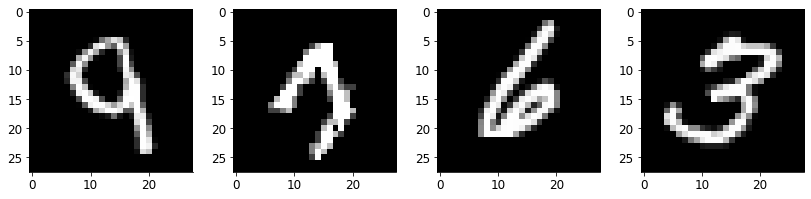

In [2]:
from mlxtend.data import loadlocal_mnist

X_train, y_train = loadlocal_mnist(
        images_path='./book_data/train-images-idx3-ubyte', 
        labels_path='./book_data/train-labels-idx1-ubyte'
        )

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(14, 3))
for ax in axs:
    ax.imshow(X_train[np.random.randint(1000)].reshape(28, 28), cmap='gray')

## Our goal: ship a PR system

We are running ahead here so don't worry if not every detail is super-clear to you at this point and try to get a sense of the big picture. In particular, don't worry about the Python codes on the first read.

The usual setup in pattern recognition problems is that of supervised learning (the two terms are all but synonymouos, minus the culture of "object recognition").

The train--test split is a hallmark of supervised learning.
While we are designing our pattern recognition system we can do whatever we want with the training set but we are not allowed to touch the test set. Once the system is designed and trained we apply it to the test set to get a sense of how it'll perform on new inputs. Of course, we assume that these new inputs will somehow resemble the ones used for training.


## Let's focus on two digits: binary classification

To avoid needless complexity, we will first try to build a _binary_ classifier which distinguishes between two classes of handwritten digits. For example, it should recognize whether the input digit is a "4" or a "7". We begin by writing some spaghetti code to extract a random sample which only contains the chosen two digits.

In [3]:
classes = [4, 7]
d = 28**2
X = np.ndarray((0, d))
y = np.ndarray((0, 1))

for cl in classes:
    X = np.vstack((X, X_train[y_train == cl]))
    y = np.vstack((y, y_train[y_train == cl, np.newaxis]))

n = 5000
shuffle_idx = np.random.choice(len(y), n)
X = X[shuffle_idx]
y = y[shuffle_idx].flatten()
y = 2*(y == classes[0]) - 1

We quickly verify that we indeed only have the two chosen digits by showing a small random sample.

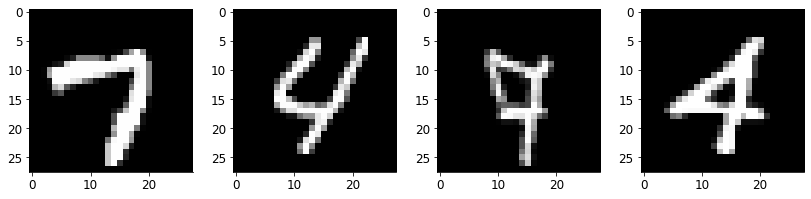

In [4]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(14, 3))
for ax in axs:
    ax.imshow(X[np.random.randint(1000)].reshape(28, 28), cmap='gray')

## Rule 0: simple ideas first

We begin with a very simple idea (although perhaps the second one will be even simpler... ymmv). In mathematics and machine learning, _simple_ often means _linear_, so we start with a linear classifier. What do we mean by linear?

Classifiers output discrete labels. In our case the label is the digit, but since we're only looking at two digits we can use labels +1 and -1. The usual way to obtain these labels is to apply a function to a digit and then take the sign of the output,

$$
	\hat{y} = \mathrm{sign}(f(\text{digit}; \theta)).
$$
We use a generic symbol $\theta$ to indicate our function has some parameters. The whole point of "learning" or "training" is to determine the parameters which yield decent classification. The hat on $\hat{y}$ indicates an _estimate_ or a _prediction_ we are making about the true label $y$.

MNIST digits are 8-bit grayscale images of size $28 \times 28$. Denoting a digit by $\mathbf{x}$, we can fancily write

$$
	\mathbf{x} \in \{0, 1, \ldots, 255\}^{28 \times 28}.
$$

Instead of working with a square grid of pixels as above, we will instead work with its vectorized version obtain by stacking all rows or all columns into a long vector of length $28^2 = 784$. The choice of rows or columns (or any other scheme) is irrelevant as long as we consistently stick to it. We will sometimes denote a vectorization of a matrix by $\mathrm{vec}(\mathbf{x})$, but here we will abuse notation (abusing notation is math--academic speak) and simply again write $\mathbf{x}$,

$$
    \mathbf{x} = 
    \begin{bmatrix}
    x_1 \\ x_2 \\ \vdots \\ x_d,
    \end{bmatrix},
$$
with $d = 784$.

We said that we will build a linear classifier. This means that $f$ is a linear function: 

$$
	f(\alpha \mathbf{x}_1 + \beta \mathbf{x}_2) = \alpha f(\mathbf{x}_1) + \beta f(\mathbf{x}_2).
$$

It can be checked that all scalar-valued linear functions of $\mathbf{x}$ are given as dot products with some vector of weights $\mathbf{w}$. Thus our classifier returns the label

$$
	\hat{y} = \mathrm{sign}\left(\sum_{i = 1}^d w_i x_i\right) = \mathrm{sign}(\mathbf{w} \cdot \mathbf{x}) = \mathrm{sign}(\langle \mathbf{w}, \mathbf{x} \rangle) = \mathrm{sign}(\mathbf{w}^T \mathbf{x}).
$$
Note that $\theta = \mathbf{w}$.


## Choosing the right weights

We now need to decide how to choose the best weights $\mathbf{w}$. In order to do that we have to clearly state what we mean by _best_, but before doing that let us try something goofy 🤭: random weights. More concretely let us independently sample each $w_i$ from a standard normal distribution. (Standard means zero mean and unit variance).

In [5]:
# generate random weights
w_random = np.random.randn(d)

# predict labels
y_est = np.sign(X @ w_random)

correct = np.sum(y_est * y == 1)
print('%d out of %d patterns correctly classified (%5.2f%%)' % (correct, n, 100*correct/n))

2373 out of 5000 patterns correctly classified (47.46%)


Not very surprisingly, a linear classifier with random weights does not achieve a particularly impressive digit classification performance. On the other hand, we can see that there the values of $\mathbf{w}_{\text{random}}^T \mathbf{x}$ vary wildly---some are very small and thus "almost" correctly classified.

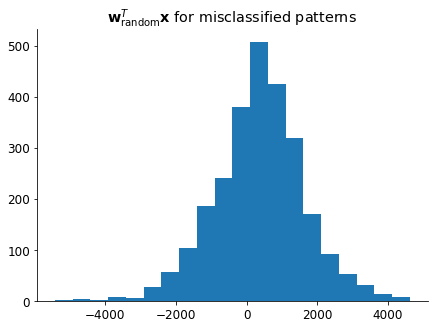

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist((X @ w_random)[y_est * y == -1], bins=20)
ax.set_title('$\mathbf{w}_{\mathrm{random}}^T \mathbf{x}$ for misclassified patterns');

A thought that naturally comes to mind is: can we somehow perturb the weights so that some of those patterns that are almost correctly classified pass to the correct class. Before figuring out how to do this visually, by geometry, we can think about the problem purely algebraically. Suppose that some training pattern $\mathbf{x}_{-1}$ whose label is $-1$ is misclassified; that is, $\mathbf{w}_{\mathrm{random}}^T \mathbf{x}_{-1} > 0$. A simple way to change the weights so that this pattern becomes correctly classified is to subtract from $\mathbf{w}_{\mathrm{rnd}}$ some multiple of $\mathbf{x}_{-1}$ since that will decrease the dot product and (for a sufficiently large multiplicative factor) make it negative, which is what we want. Indeed, letting $\alpha > 0$

$$
    (\mathbf{w}_{\mathrm{rnd}} - \alpha \mathbf{x}_{-1})^T \mathbf{x}_{-1}
    =
    \mathbf{w}_{\mathrm{rnd}}^T \mathbf{x}_{-1} - \alpha \| \mathbf{x}_{-1} \|^2  
    < 
    \mathbf{w}_{\mathrm{rnd}}^T \mathbf{x}_{-1}.
$$
For $\alpha$ big enough this quantity will become negative. Similarly, if a pattern $\mathbf{x}_{+1}$ with label $+1$ is misclassified so that $\mathbf{w}_{\mathrm{random}}^T \mathbf{x}_{+1} < 0$, then we could _add_ a multiple of $\mathbf{x}_{+1}$ to make the inner product positive. For $\alpha > 0$,

$$
    (\mathbf{w}_{\mathrm{rnd}} + \alpha \, \mathbf{x}_{+1})^T \mathbf{x}_{+1}
    =
    \mathbf{w}_{\mathrm{rnd}}^T \mathbf{x}_{+1} + \alpha \| \mathbf{x}_{+1} \|^2  
    > 
    \mathbf{w}_{\mathrm{rnd}}^T \mathbf{x}_{+1}.
$$
For $\alpha$ big enough this quantity will become positive.

We can visualize this by pretending that we work with "digits" that only have 2 pixels (instead of $28 \times 28 = 784$). The usefulness of this simplification is that now every "digit" can be identified with a point in the plane with coordinates $(x, y) = (\textsf{pixel 1}, \textsf{pixel 2})$. Consider the situation in the left subfigure below. The weight vector $\mathbf{w}$ defines a line which splits the space into a positive and a negative halfspace. All points in the upper halfspace which is in the direction of $\mathbf{w}$ form accute angles ($< 90^\circ$) with $\mathbf{w}$ and thus have a positive inner product with $\mathbf{w}$ (because the cosine of an accute angle is positive). Similarly, all points in the lower halfspace form obtuse angles with $\mathbf{w}$ and thus have negative inner products with $\mathbf{w}$. If blue squares are the positive class (label +1) and red circles the negative class (label -1), then we see from this picture that the current classifier misclassifies three training patterns. 

| before     | after      |
| -------- | --------- |
| {{fig2Da}} | {{fig2Db}} |

Let us try to perturb (rotate) $\mathbf{w}$ so that the misclassified red circle closest to the boundary becomes correctly classified. Let's call this pattern $\tilde{\mathbf{x}}$. We have that

$$
\mathbf{w}^T \tilde{\mathbf{x}} > 0 
$$
but it should be negative. Per above discussion, we want to compute a perturbation in the direction of negative $\tilde{\mathbf{x}}$, say $- \alpha \tilde{\mathbf{x}}$ so that

$$
    (\mathbf{w} - \alpha \tilde{\mathbf{x}})^T \tilde{\mathbf{x}} = 0
$$
which will place $\tilde{\mathbf{x}}$ exactly on the decision boundary (exactly on the line). Thus

$$
    \mathbf{w}^T \tilde{\mathbf{x}} - \alpha \tilde{\mathbf{x}}^T \tilde{\mathbf{x}} = 0 
    \Longrightarrow
    \alpha = \frac{\mathbf{w}^T \tilde{\mathbf{x}}}{\tilde{\mathbf{x}}^T \tilde{\mathbf{x}}}. 
$$

Let's now apply these ideas to digit classification.

In [7]:
# find indices of misclassfied examples
idx_miss = np.where(y != y_est)[0]

idx_miss
i = idx_miss[np.argmin(np.abs((X @ w_random)[idx_miss]))]
dot_i = np.dot(X[i], w_random)
print('The smallest absolute dot product is %.2e' % (dot_i,))

The smallest absolute dot product is 3.01e-01


We identified the pattern (a digit) which is the closest to the linear decision boundary in the sense of angle). Note that this does not mean that it is the closest in distance.
```{admonition} Why?
:class: tip, dropdown
The dot product $\mathbf{a}^T \mathbf{b} = \| \mathbf{a} \| \| \mathbf{b} \| \cos \angle(\mathbf{a}, \mathbf{b})$. Thus if the digit in question has a particularly large Euclidean norm (it is far from the origin), the angle with the boundary could be small but the distance to the boundary still large.
```

Now we add the computed perturbation to the weights, but we scale it by a number slightly larger than 1 so that the digit does not land on the decision boundary but (barely) crosses to the other side.

In [8]:
w_bumped = w_random - 1.000001 * X[i] * dot_i \
                / np.linalg.norm(X[i])**2
y_est_bumped = np.sign(X @ w_bumped)
correct_bumped = np.sum(y_est_bumped * y == 1)
print('Correct before: %d/%d, correct after: %d/%d' % (correct, n, correct_bumped, n))

Correct before: 2373/5000, correct after: 2374/5000


We see that the new weights indeed correctly classify one additional digit which was previously misclassified. The reason to multiply by 1.000001 instead of, for example, by 2, is that in this latter case we would likely mess things up for some digits that used to be classified correctly (as well as correct things for _other_ digits that used to be misclassified). A simple count would then not be sufficient to check whether the ideas work.

## Let's make this into an algorithm

A question comes to mind: even if we mess things up for some other digits, we could then apply our perturbation ideas to them, and cycle over misclassified digits until, hopefully, most of them become correctly classified. As we will see, this is not always possible (the patterns should be _linearly separable_ for it to be possible; in the above figure, there should exist a line which perfectly separates squares and circles). But it can often work quite well. Our strategy is as follows: for each misclassified pattern we will update the weights in the direction which would make the pattern correctly classified. A parameter called _learning rate_ will determine how strongly we bump the weights in that direction. Once we go through all training patterns we will start from the beginning, and repeat this process until the estimated classes (signs of dot products) stabilize, or, simpler, for some set number of iterations.

In [9]:
def train(X, y, lr=0.1, n_iter=30):
    # X : a (n, d) matrix with rows being training examples (digits)
    # y : a (d, 1) vector of labels

    n, d = X.shape
    w = np.zeros((d,))
    
    for i_iter in range(n_iter):
        for i_example in range(n):
            y_est = np.sign(np.dot(X[i_example], w))

            if y_est != y[i_example]:
                w += lr * X[i_example] * y[i_example]
        
    return w

(Check class notes to see a better implementation.) We now apply this to MNIST.

In [10]:
w = train(X, y)

error_count = np.sum(np.sign(X @ w) * y < 0 )
print("%d out of %d patterns are misclassified" % (error_count, n))

9 out of 5000 patterns are misclassified


A much better result than what we initially obtained with random weights! Let's try to visualize the digits in a way that clearly shows that we've got ourselves some good weights. We need a way to represent the digits which live in a $28 \times = 784$ dimensional space by points in the 2D plane. We will do it like this: choose two directions $\mathbf{e}_1, \mathbf{e}_2 \in \mathbb{R}^{784}$ and then represent a digit $\mathbf{x}$ by a point $(\mathbf{e}_1^T \mathbf{x}, \mathbf{e}_2^T \mathbf{x})$ in the plane. We'll choose $\mathbf{e}_2 = \mathbf{w} / \| \mathbf{w} \|$ becase we're interested in what the distribution of points looks like along the direction of the weights. Then we'll set $\mathbf{e}_1$ to some unit vector orthogonal to $\mathbf{e}_2$. Since there are 783 orthogonal directions, we choose one at random. You can check that the computed vectors are indeed orthogonal.

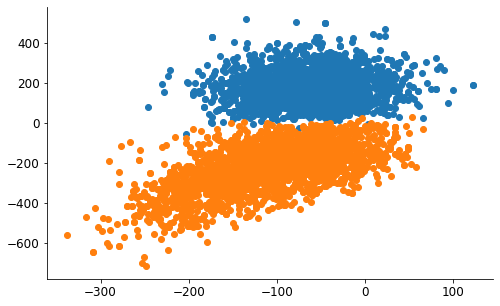

In [11]:
w_orth = np.random.randn(d) 
w_orth -= w * np.dot(w_orth, w) / np.linalg.norm(w)**2

X_w = X @ w / np.linalg.norm(w)
X_orth = X @ w_orth / np.linalg.norm(w_orth)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_orth[y==1], X_w[y==1])
ax.scatter(X_orth[y==-1], X_w[y==-1]);

## What do the weights do?

An important benefit of using simple linear classifiers is that we can visualize the weights as a 28 $\times$ 28 image and see exactly how the different digits are distinguished. Such _interpretability_ is a desirable property of pattern recognition systems, but it's often absent in modern approaches based on large deep neural networks.

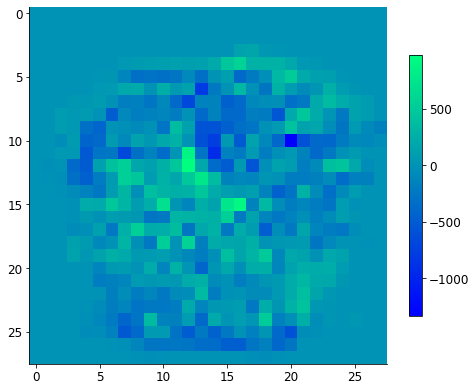

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(w.reshape(28, 28), cmap='winter')
_ = fig.colorbar(im, ax=ax, shrink=0.6)

## A different classifier: counting neighbor labels

We have successfully constructed our first pattern classification system. The idea was perhaps a bit abstract and probably different from how you would go about classifying patterns by hand. 

```{figure} ./images/Meyer_Lemon.jpg
A Meyer lemon.
```
Imagine I ask you to classify a citrus as either a Meyer lemon or an ordinary lemon. I also give you 30 ordinary lemons and 30 Meyer lemons. The way you'd solve this problem is most likely by comparing the lemon to the two piles and assigning it to the pile that contains more similar lemons. 

Let's turn this intuitive approach into an algorithm. The idea is as follows: for a patter we want to classify, we will find $k$ patterns that are closest to it in the training set. Then we will do a majority vote: find the label that occurs most often among the neighbors and declare this label to be our estimate.

In [13]:
k = 31
error_count = 0
for i_example in range(n):

    # compute distance from the current example
    # to all other
    dist2 = np.sum((X - X[i_example])**2, axis=1)

    # find k closest examples, ignoring zero 
    # distance to the current one
    k_closest_idx = np.argsort(dist2)[1:k + 1]

    # do majority vote on the corresponding labels
    y_est = np.sign(y[k_closest_idx].sum())

    # check for errors
    if y_est * y[i_example] < 0:
        error_count += 1

print("The number of misclassified points is: ", error_count)

The number of misclassified points is:  35


This is pretty slow but in the end we get quite a decent result. The right thing to do would be to test how this works for patterns outside of the training set, but for the moment let's just keep playing around and building intuition.

## Which $k$ works best? 

In the above example we chose the number of neighbors as $k = 31$ for no particular reason. Intutively, this value should have a marked effect on the behavior of our classifier. Let us test many different values of $k$ to figure out which one is the best. Before we do that... we need to do something with the code above which is far too slow to run over and over for different $k$. The idea is to leverage fast mathematical primitives used by `numpy`, in particular matrix multiplication. To understand what the formula in the below code does, check out this [paper about Euclidean distance matrices](https://infoscience.epfl.ch/record/221380/files/EDM%283%29.pdf).

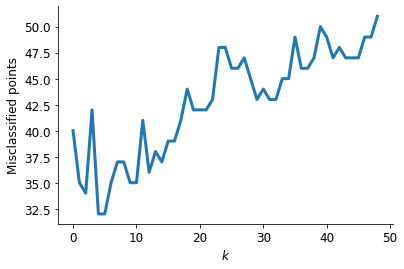

In [14]:
ec = []
G = X @ X.T # ref: EDMs -> hw
dist22 = np.diag(G)[:, np.newaxis] - 2*G + np.diag(G)[np.newaxis, :]
sorted_dist_idx = np.argsort(dist22, axis=1)

for k in range(2, 100, 2):
    k_closest_idx = sorted_dist_idx[:, 1:k + 1]
    y_est = np.sign(y[k_closest_idx].sum(axis=1))
    error_count = (y_est * y <= 0).sum()    
    ec.append(error_count)

plt.plot(ec, linewidth=3)
plt.xlabel('$k$')
plt.ylabel('Misclassified points');

It seems that both $k$ too small and $k$ too large are bad. Can you guess why?

It would be great to get some visual intution about what is going on, but we cannot easily do that for the $28 \times 28$ digits: we would have to find a way to visualize 784-dimensional space. Luckily there are many datasets with a small number of features which make more sense.


## The Iris flower datset

Another legendary dataset used by almost every data science course on the planet is the Iris flower dataset compiled by Ronald Fisher, probably the most important statistician of all time (and a complicated person privately and publicly).

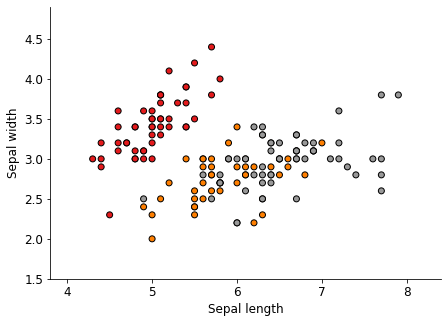

In [15]:
# Modified from Gaël Varoquaux

from sklearn import datasets

iris = datasets.load_iris()
X_iris = iris.data[:, :2]  # take only the first two features
y_iris = iris.target

x_min, x_max = X_iris[:, 0].min() - 0.5, X_iris[:, 0].max() + 0.5
y_min, y_max = X_iris[:, 1].min() - 0.5, X_iris[:, 1].max() + 0.5

plt.figure(figsize=(7, 5))

plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

plt.xlim(x_min, x_max)
_ = plt.ylim(y_min, y_max)

We again focus on two classes:

In [16]:
excluded_class = 2
classes = np.setdiff1d([0, 1, 2], excluded_class)
X = X_iris[y_iris != excluded_class]
y = y_iris[y_iris != excluded_class]
y[y == classes[0]] = -1
y[y == classes[1]] = 1

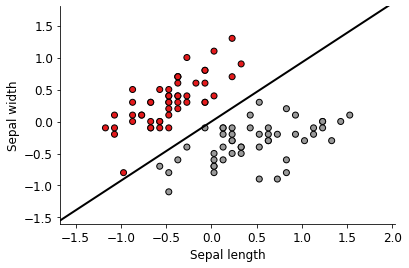

In [17]:
X -= X.mean(axis=0)

w = train(X, y)
w /= np.linalg.norm(w)
w_orth = np.array([1, -w[0] / w[1]])

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
s = 20
plt.plot([-s*w_orth[0], s*w_orth[0]], [-s*w_orth[1], s*w_orth[1]], 'k', linewidth=2)
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.xlim(x_min, x_max)
_ = plt.ylim(y_min, y_max)

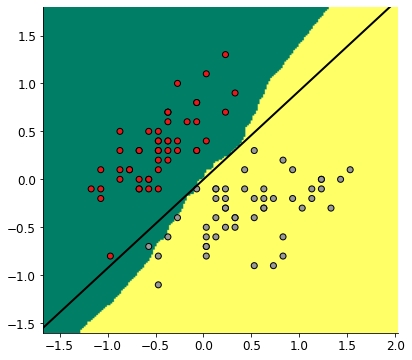

In [18]:
k = 51
n_points = 200
x_ = np.linspace(x_min, x_max, n_points)
y_ = np.linspace(y_min, y_max, n_points)

xx, yy = np.meshgrid(x_, y_)
label = np.zeros(xx.shape)

for i in range(n_points):
    for j in range(n_points):
        point = np.array([xx[i, j], yy[i, j]]) # classify current point
        knn_idx = np.argsort(np.sum((X - point)**2, axis=1))[:k]
        label[i, j] = np.sign(y[knn_idx].sum())

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=(y/2+1), cmap=plt.cm.Set1, edgecolor="k")
plt.plot([-s*w_orth[0], s*w_orth[0]], [-s*w_orth[1], s*w_orth[1]], 'k', linewidth=2)
_ = plt.imshow(np.flipud(label), cmap='summer', extent=[x_min, x_max, y_min, y_max])

## The perceptron


## Well, we first reinvented the _perceptron_

```{figure} ./images/rosenblatt.jpg
---
scale: 50%
align: right
---
```  
The perceptron is a brainchild of Frank Rosenblatt who was an American psychologist working on artificial intelligence. The algorithm received major press coverage at the time, with the hype not too different from what we have witnessed over the past decade with deep learning (with the notable difference that the perceptron was indeed quite limited in its capabilities and generalizations were far away). Frank Rosenblatt's discovery has huge implications today since the perceptron is more or less the artificial neuron used in today's deep neural networks, and the training algorithm (which is really the key) is related to error backpropagation used to train modern deep neural networks.


```{figure} ./images/nytp.png
---
scale: 50%
align: left
---
The New York Times, 1958
```


```{figure} ./images/0925_rosenblatt4.jpg
---
scale: 50%
align: left
---
The New York Times, 1958
```

## We then reinvented $k$ nearest neighbors

```{figure} ./images/tomcover.jpg
---
scale: 50%
align: left
---
```
- Evelyn Fix & Joseph Lawson Hodges Jr. circa 1951
- Expanded and analyzed by Thomas Cover (on the left)
- Despite simplicity it is an incredibly useful technique, and one which has been keeping machine learning theorists busy for many years 

## Some of the questions we must answer

- Which classifier is better?
- What does "better" even mean?

## We have been committing a crime

- We "trained", "validated", and "tested" on one and the same dataset
- For $k$NN it's even a bit silly (consider the iris example)


## This course

- "Pattern recognition" very close to "machine learning"
- Focus in PR is on "supervised learning"
    - classification
    - prediction
- But "unsupervised learning" plays a key role
    - representation learning
    - feature maps: learning good features

## Beware

- The language of pattern recognition is mathematical
- We will give intuition but to really get it, make sure you know your probability and linear algebra well
- That is a good thing; without the formal understanding PR would not be where it's now
- Let me tell you a story about interviewing people for CeDA...


## Key mathematical tools

### Probability theory (and statistics)

- What is a random variable? A random vector?
- A joint distribution? A conditional distribution? An expectation?
- What are independent random variables?
- ...

### Linear algebra

- What does $\mathbf{w}^T \mathbf{x}$ mean? How about $\| \mathbf{x} \|$?
- Why is $\arg \min_{\mathbf{w}} ~ \| \mathbf{y} - \mathbf{X} \mathbf{w} \|^2 + \lambda \| \mathbf{x} \|^2 $ precisely $\mathbf{x}^* = ( \mathbf{X}^T \mathbf{X} + \lambda \mathbf{I})^{-1} \mathbf{X}^T \mathbf{y}$
- What does it mean to invert a matrix?
- What is a projection?
- ...